In [143]:
from IPython.display import display
from openbb_terminal.sdk import openbb

import datetime
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import pandas as pd
import seaborn as sns
import tqdm

In [129]:
def ticker_to_yahoo_format(t):
    return '.'.join(t.split(':')[::-1])[:-1]

def get_daily_data_with_today(ticker, today, start_date=None, n_days=None):
    if ticker[0] == 'H':
        ticker = ticker_to_yahoo_format(ticker)
    if start_date is None:
        start_date = today - (datetime.timedelta(days=n_days if n_days is not None else 365))
    data_until_today = openbb.stocks.load(
        ticker,
        interval=1440,
        start_date=start_date,
        verbose=False
    ).drop('Adj Close', axis=1)
    data_today = openbb.stocks.load(
        ticker,
        interval=1,
        start_date=today - datetime.timedelta(days=1),
        end_date=today,
        verbose=False
    ).drop('Adj Close', axis=1)
    data_today = data_today[data_today.index.time != datetime.time(16, 8)]
    data_today = data_today.groupby(data_today.index.floor('1D')).agg({'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last', 'Volume': 'sum'})
    data_today = data_today[data_today.index.date == today.date()]
    if not len(data_today):
        raise ValueError('No minute data for today')
    return pd.concat([data_until_today[data_until_today.index < today], data_today])

def SMMA(s, n):
#     никто все равно так не считает, все берут ЕМА обычный
#     а раз все берут ЕМА, то и "самосбывающееся пророчество" по этому индикатору происходит по ЕМА
#     return s.rolling(n).mean().dropna().ewm(alpha=1/n).mean()
    return s.ewm(alpha=1/n).mean()

def RSI(data, n=14):
    d = data['Close']
    U = SMMA(np.maximum(data['Close'] - data['Close'].shift(1), 0).dropna(), n)
    D = SMMA(np.maximum(data['Close'].shift(1) - data['Close'], 0).dropna(), n)
    return 100 * U / (U + D + 1e-25)

In [132]:
green_tickers = """HKG:0388
HKG:3988
HKG:2331
HKG:0669
HKG:9988
HKG:2015
HKG:0857
HKG:0386
HKG:1088
HKG:1347
HKG:9999
HKG:1928
HKG:1109"""

blue_tickers = """HKG:0939
HKG:9866
HKG:9618
HKG:2688
HKG:0992
HKG:0268
HKG:2518
HKG:9888
HKG:9626
HKG:0700
HKG:1113"""

In [177]:
rsi_data = {}
for ticker in tqdm.tqdm((green_tickers + '\n' + blue_tickers).split('\n')):
    data = get_daily_data_with_today(ticker, datetime.datetime.combine(datetime.date.today(), datetime.time()))
    rsi_data[ticker] = RSI(data)
rsi_data = pd.DataFrame(rsi_data)
rsi_data.index = [str(x)[-5:].replace('-', '/') for x in rsi_data.index.date]
rsi_data.columns = [x[4:] for x in rsi_data.columns]

100%|███████████████████████████████████████████| 24/24 [00:32<00:00,  1.37s/it]


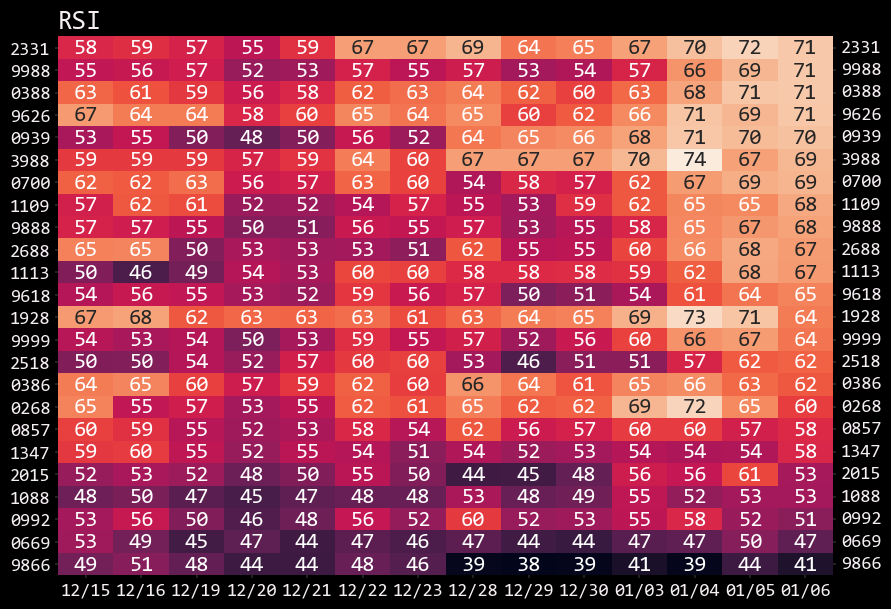

In [178]:
plt.figure(figsize=(10, 7))
ax = sns.heatmap(rsi_data.T.iloc[:, -14:].sort_values(rsi_data.index[-1], ascending=False), annot=True, cbar=False)
ax.tick_params(left=True, labelleft=True, right=True, labelright=True, rotation=0)
plt.title('RSI')
plt.show()

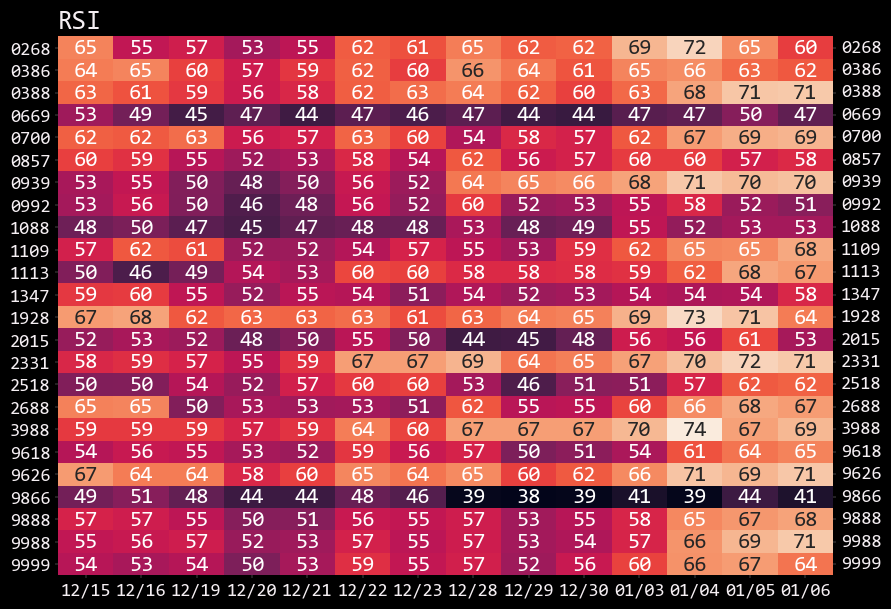

In [179]:
plt.figure(figsize=(10, 7))
ax = sns.heatmap(rsi_data.T.iloc[:, -14:].sort_index(), annot=True, cbar=False)
ax.tick_params(left=True, labelleft=True, right=True, labelright=True, rotation=0)
plt.title('RSI')
plt.show()

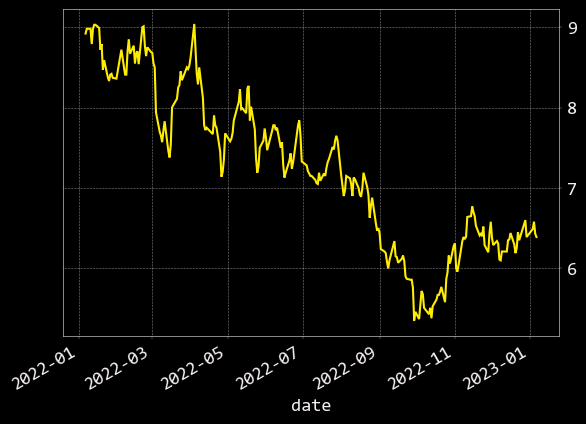

<AxesSubplot: xlabel='date'>

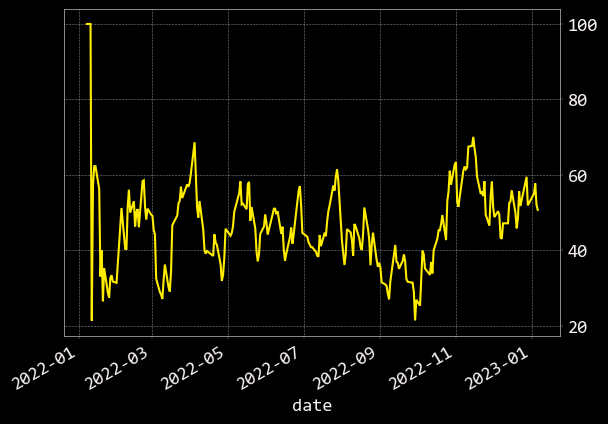

In [131]:
ax = data.Close.plot()
plt.show()
RSI(data).plot()

<AxesSubplot: xlabel='date'>

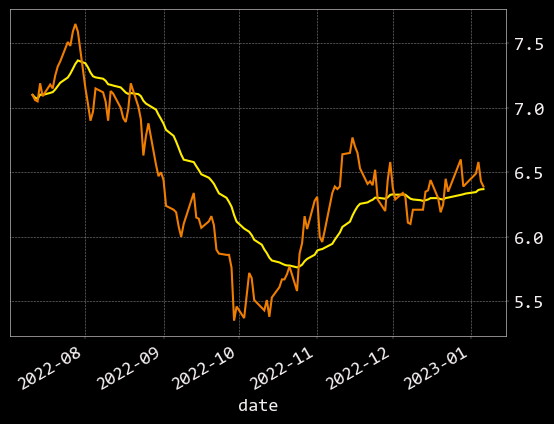

In [125]:
ax = data['Close'].ewm(alpha=1/14).mean().plot()
data['Close'].plot(ax=ax)

In [39]:
datetime.datetime(2022, 12, 1).date()

datetime.date(2022, 12, 1)

In [35]:

daily_data = openbb.stocks.load(ticker_to_yahoo_format(ticker), interval=1440, start_date=datetime.datetime(2023, 1, 1))

Loading Intraday 1min data for 0992.HK with starting period 2023-01-01.

Loading Daily data for 0992.HK with starting period 2023-01-03.

In [44]:
data[data.index.time != datetime.time(16, 8)].groupby(data[data.index.time != datetime.time(16, 8)].index.floor('1D')).last().index[-1].date()

datetime.date(2023, 1, 6)

In [23]:
data.groupby(data.index.date).last()

,Open,High,Low,Close,Adj Close,Volume
2023-01-03,6.49,6.49,6.17,6.43,6.43,1982000
2023-01-04,6.58,6.58,6.52,6.52,6.52,4804000
2023-01-05,6.43,6.43,6.29,6.29,6.29,4092000
2023-01-06,6.39,6.39,6.38,6.38,6.38,118000


In [15]:
daily_data

,Open,High,Low,Close,Adj Close,Volume
date,,,,,,
2023-01-03,6.26,6.52,6.21,6.49,6.49,23577147
2023-01-04,6.57,6.63,6.49,6.58,6.58,24694211
2023-01-05,6.58,6.62,6.38,6.43,6.43,34116642


In [8]:
data.index.date[0]

datetime.date(2023, 1, 4)